In [1]:
from platform import python_version

print(python_version())

3.7.9


In [2]:
import os
os.chdir('../..')

In [3]:
import numpy as np
import pandas as pd

import tensorflow as tf

import matplotlib.pyplot as plt

from sklearn.mixture import BayesianGaussianMixture, GaussianMixture
from sklearn.model_selection import ParameterGrid

# For the Python notebook
%matplotlib inline
%reload_ext autoreload
%autoreload 2

# Functions

In [6]:
def TGAN_encoding(data):
    model = GaussianMixture(n_components=5)
    model.fit(data)
    
    return model

In [7]:
def CTGAN_encoding(data):
    model = BayesianGaussianMixture(
            n_components = 10,
            weight_concentration_prior_type='dirichlet_process',
            weight_concentration_prior=0.001,
            n_init=1)
    model.fit(data)
    
    valid_component_indicator = model.weights_ > 0.005
    
    if sum(valid_component_indicator) < 10:
        print("  Some mixtures are ignored ({:d})".format(10-sum(valid_component_indicator)))
    
    return model

In [9]:
class Peak:
    def __init__(self, startidx):
        self.born = self.left = self.right = startidx
        self.died = None

    def get_persistence(self, seq):
        return float("inf") if self.died is None else seq[self.born] - seq[self.died]

def get_persistent_homology(seq):
    peaks = []
    # Maps indices to peaks
    idxtopeak = [None for s in seq]
    # Sequence indices sorted by values
    indices = range(len(seq))
    indices = sorted(indices, key = lambda i: seq[i], reverse=True)

    # Process each sample in descending order
    for idx in indices:
        lftdone = (idx > 0 and idxtopeak[idx-1] is not None)
        rgtdone = (idx < len(seq)-1 and idxtopeak[idx+1] is not None)
        il = idxtopeak[idx-1] if lftdone else None
        ir = idxtopeak[idx+1] if rgtdone else None

        # New peak born
        if not lftdone and not rgtdone:
            peaks.append(Peak(idx))
            idxtopeak[idx] = len(peaks)-1

        # Directly merge to next peak left
        if lftdone and not rgtdone:
            peaks[il].right += 1
            idxtopeak[idx] = il

        # Directly merge to next peak right
        if not lftdone and rgtdone:
            peaks[ir].left -= 1
            idxtopeak[idx] = ir

        # Merge left and right peaks
        if lftdone and rgtdone:
            # Left was born earlier: merge right to left
            if seq[peaks[il].born] > seq[peaks[ir].born]:
                peaks[ir].died = idx
                peaks[il].right = peaks[ir].right
                idxtopeak[peaks[il].right] = idxtopeak[idx] = il
            else:
                peaks[il].died = idx
                peaks[ir].left = peaks[il].left
                idxtopeak[peaks[ir].left] = idxtopeak[idx] = ir

    # This is optional convenience
    pers = np.array([p.get_persistence(seq) for p in peaks])
    
    return sorted(peaks, key=lambda p: p.get_persistence(seq), reverse=True)

In [88]:
def encoding(data):
    n_bins = 50
    thresh = 1e-3
    
    hist = np.histogram(data, bins=n_bins, density=True)
    
    peaks = get_persistent_homology(hist[0])
    
    pers = np.array([p.get_persistence(hist[0]) for p in peaks])
    
    print(pers)
    
    n_peaks = sum(pers > 1e-3)-1
    
    print("  Found {} peaks!".format(n_peaks))
    
    if n_peaks < 2:
        n_modes = 10
    else:
        n_modes = min(n_peaks, 10)
        
    print("  Starting encoding with {} components.".format(n_modes))
    while True:
        model = BayesianGaussianMixture(
            n_components=n_modes, 
            max_iter=200, 
            n_init = 10,
            init_params = 'kmeans',
            reg_covar=0,
            weight_concentration_prior_type = 'dirichlet_process',
            mean_precision_prior=.8,
            tol=1e-5,
            weight_concentration_prior = 1e-5)
        model.fit(data)
        
        pred_ = np.unique(model.predict(data))

        if len(pred_) == n_modes:
            print("  Predictions were done on {:d} components => FINISHED!".format(n_modes))
            return model
        else:
            n_modes = len(pred_)
            print("  Predictions were done on only {:d} components => Encode with {:d} components".format(n_modes, n_modes))
    

# TEST

In [94]:
dataset = 'Chicago'
continuous_columns = ["distance", "age", "departure_time"]

In [91]:
dataset = 'LPMC'
continuous_columns = ['start_time_linear', 'age', 'distance', 'dur_walking', 'dur_cycling', 'dur_pt_access', 'dur_pt_rail', 'dur_pt_bus', 'dur_pt_int', 'dur_driving', 'cost_transit', 'cost_driving_fuel', 'driving_traffic_percent']

Testing encoding for column distance
  TGAN encoding...
  CTGAN encoding...


D:\Users\glede\anaconda3\envs\py37\lib\site-packages\sklearn\mixture\_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,


  Some mixtures are ignored (1)
  New encoding...
[           inf 2.54156142e-04 2.06501865e-04 1.74732347e-04
 1.58847589e-04 9.53085531e-05 6.35390354e-05 5.55966560e-05
 4.76542766e-05 3.97118971e-05 7.94237943e-06]
  Found 0 peaks!
  Starting encoding with 10 components.


D:\Users\glede\anaconda3\envs\py37\lib\site-packages\sklearn\mixture\_base.py:282: ConvergenceWarning: Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,


  Predictions were done on 10 components => FINISHED!


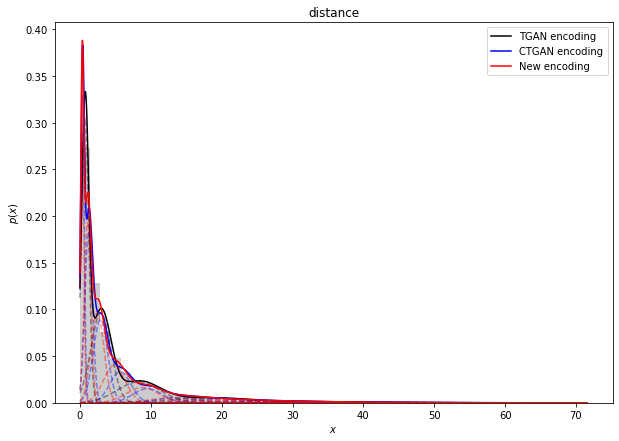

Testing encoding for column age
  TGAN encoding...
  CTGAN encoding...


D:\Users\glede\anaconda3\envs\py37\lib\site-packages\sklearn\mixture\_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,


  New encoding...
[           inf 9.93768440e-03 7.61715097e-03 1.98985741e-03
 1.90863874e-03 1.66498273e-03 1.35171072e-03 8.06385365e-04
 7.13564028e-04 7.13564028e-04 3.24874680e-04 2.55258677e-04
 1.79841340e-04 2.90066678e-05]
  Found 6 peaks!
  Starting encoding with 6 components.


D:\Users\glede\anaconda3\envs\py37\lib\site-packages\sklearn\mixture\_base.py:282: ConvergenceWarning: Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,


  Predictions were done on 6 components => FINISHED!


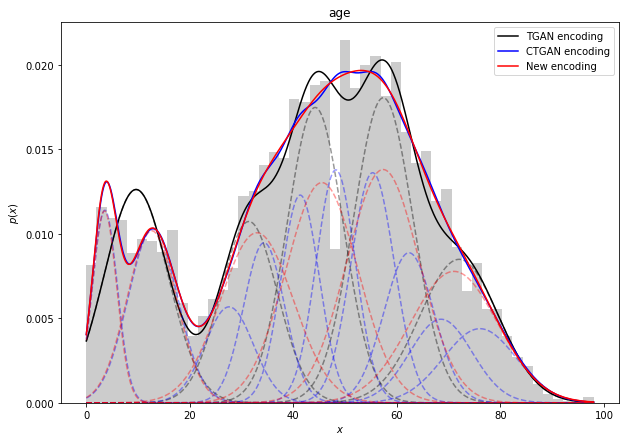

Testing encoding for column departure_time
  TGAN encoding...
  CTGAN encoding...


D:\Users\glede\anaconda3\envs\py37\lib\site-packages\sklearn\mixture\_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,


  Some mixtures are ignored (1)
  New encoding...
[           inf 2.47956818e-02 1.48394807e-02 1.46972492e-02
 1.40572077e-02 1.17577994e-02 4.36176429e-03 2.89203936e-03
 2.74980792e-03 7.11157221e-05 2.37052407e-05]
  Found 8 peaks!
  Starting encoding with 8 components.


D:\Users\glede\anaconda3\envs\py37\lib\site-packages\sklearn\mixture\_base.py:282: ConvergenceWarning: Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,


  Predictions were done on 8 components => FINISHED!


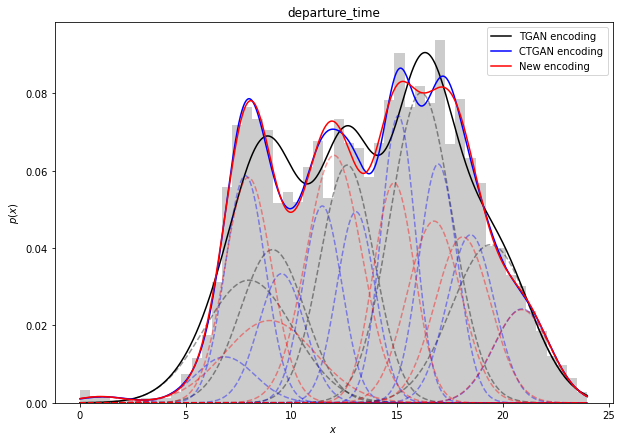

In [95]:
df = pd.read_csv('../data/{}/data.csv'.format(dataset))

for col in continuous_columns:
    print("Testing encoding for column {}".format(col))
    data = np.array(df[col]).reshape(-1, 1)
    
    print("  TGAN encoding...")
    tgan_gm = TGAN_encoding(data)
    print("  CTGAN encoding...")
    ctgan_gm = CTGAN_encoding(data)
    print("  New encoding...")
    gm = encoding(data)
    
    plt.figure(figsize=(10,7))
    plt.hist(data, 50, density=True, histtype='stepfilled', 
         alpha=0.4, color='gray')

    x = np.linspace(np.min(data), np.max(data), 1000)
    
    # Plot TGAN encoding
    logprob = tgan_gm.score_samples(x.reshape(-1, 1))
    responsibilities = tgan_gm.predict_proba(x.reshape(-1, 1))
    pdf = np.exp(logprob)
    pdf_individual = responsibilities * pdf[:, np.newaxis]
    plt.plot(x, pdf, '-k', label='TGAN encoding')
    plt.plot(x, pdf_individual, '--k', alpha=0.4)
    
    # Plot CTGAN encoding
    logprob = ctgan_gm.score_samples(x.reshape(-1, 1))
    responsibilities = ctgan_gm.predict_proba(x.reshape(-1, 1))
    pdf = np.exp(logprob)
    pdf_individual = responsibilities * pdf[:, np.newaxis]
    plt.plot(x, pdf, '-b', label='CTGAN encoding')
    plt.plot(x, pdf_individual, '--b', alpha=0.4)
    
    # Plot new encoding
    logprob = gm.score_samples(x.reshape(-1, 1))
    responsibilities = gm.predict_proba(x.reshape(-1, 1))
    pdf = np.exp(logprob)
    pdf_individual = responsibilities * pdf[:, np.newaxis]
    plt.plot(x, pdf, '-r', label='New encoding')
    plt.plot(x, pdf_individual, '--r', alpha=0.4)

    plt.xlabel('$x$')
    plt.ylabel('$p(x)$')
    plt.title(col)
    plt.legend()
    plt.savefig('../figures/VGM/{}_{}.png'.format(dataset, col), bbox_inches='tight')
    plt.show()